# AlexNet on MNIST

In [1]:
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
# import pytorch_lightning as pl
from torch import nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

## 1. Load Date & Data Transform

In [2]:
# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据预处理：将28x28的灰度图转换为224x224的RGB图
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.Grayscale(num_output_channels=3),  # 灰度图转RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081]),  # MNIST数据集的均值和标准差
])

# 加载训练和测试数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 2. Define model

In [3]:
# 定义AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 3. Parameters

In [4]:
# 初始化模型
model = AlexNet().to(device)

In [5]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [6]:
from torchsummary import summary

In [7]:
summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]          23,296
              ReLU-2           [-1, 64, 60, 60]               0
         MaxPool2d-3           [-1, 64, 29, 29]               0
            Conv2d-4          [-1, 192, 29, 29]         307,392
              ReLU-5          [-1, 192, 29, 29]               0
         MaxPool2d-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
             ReLU-12          [-1, 256, 14, 14]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

## 4. Forward & Backward Validation

In [8]:
# 获取一个批次的数据
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# 前向传播
outputs = model(images)
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
print(loss)

# 清除之前的梯度
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.zero_grad()

# 反向传播
loss.backward()
print("Backward pass successful.")

tensor(2.3039, device='cuda:0', grad_fn=<NllLossBackward0>)
Backward pass successful.


## 5. Training & with different lr

In [9]:
import torch.optim as optim

LR = [0.00001, 0.0001, 0.001, 0.005, 0.01]
TLS = []
VLS = []
TACC = []
VACC = []
MODELS = []

for lr in LR:
    print(f'>> lr: {lr}')
    model = AlexNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = 2
    tls = []
    vls = []
    taccs = []
    vaccs = []
    
    def train_epoch():
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将输入和标签移到GPU
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item() * inputs.size(0)
            
            tls.append(loss.item())
            taccs.append(((predicted == labels).float()).mean().item())
        return running_loss / len(train_dataset)
    
    def validate_epoch():
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # 将输入和标签移到GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
                vls.append(loss.item())
                vaccs.append(((predicted == labels).float()).mean().item())
        return running_loss / len(test_dataset), correct / total
    
    for epoch in range(num_epochs):
        train_loss = train_epoch()
        val_loss, val_acc = validate_epoch()
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    print()
    TLS.append(tls)
    VLS.append(vls)
    TACC.append(taccs)
    VACC.append(vaccs)
    MODELS.append(model)

>> lr: 1e-05
Epoch 1/2, Train Loss: 0.3153, Val Loss: 0.0682, Val Acc: 0.9765
Epoch 2/2, Train Loss: 0.0806, Val Loss: 0.0516, Val Acc: 0.9827

>> lr: 0.0001
Epoch 1/2, Train Loss: 0.1423, Val Loss: 0.0501, Val Acc: 0.9854
Epoch 2/2, Train Loss: 0.0480, Val Loss: 0.0285, Val Acc: 0.9915

>> lr: 0.001
Epoch 1/2, Train Loss: 2.3037, Val Loss: 2.3012, Val Acc: 0.1135
Epoch 2/2, Train Loss: 2.3014, Val Loss: 2.3011, Val Acc: 0.1135

>> lr: 0.005
Epoch 1/2, Train Loss: 28.5422, Val Loss: 2.3018, Val Acc: 0.1135
Epoch 2/2, Train Loss: 2.3028, Val Loss: 2.3025, Val Acc: 0.1135

>> lr: 0.01
Epoch 1/2, Train Loss: 3942.4598, Val Loss: 2.3021, Val Acc: 0.1010
Epoch 2/2, Train Loss: 2.3025, Val Loss: 2.3020, Val Acc: 0.1135



>> lr: 1e-05


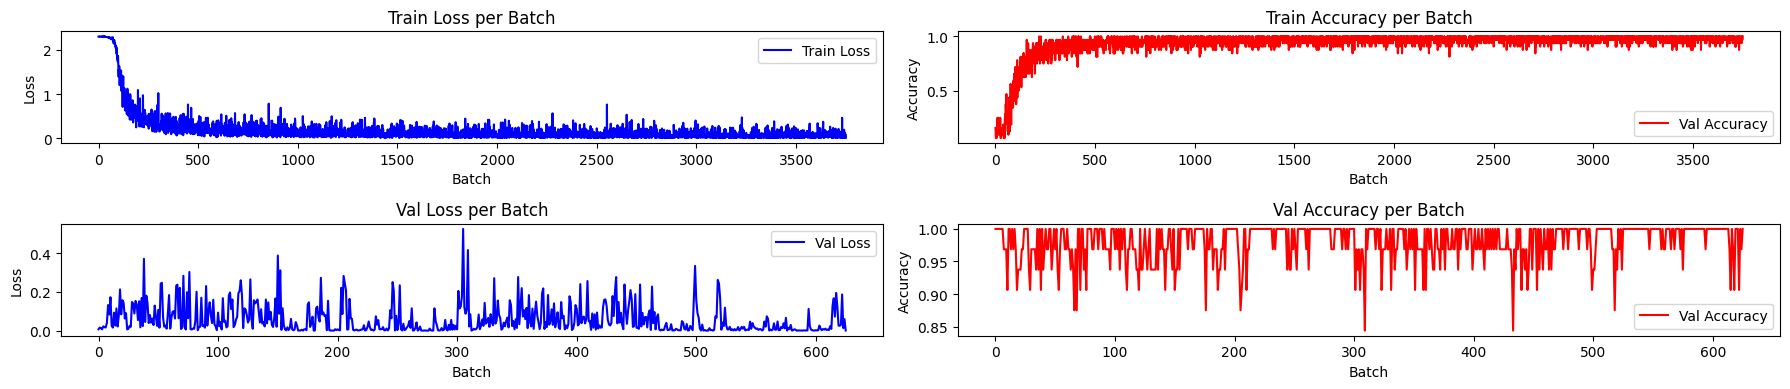

>> lr: 0.0001


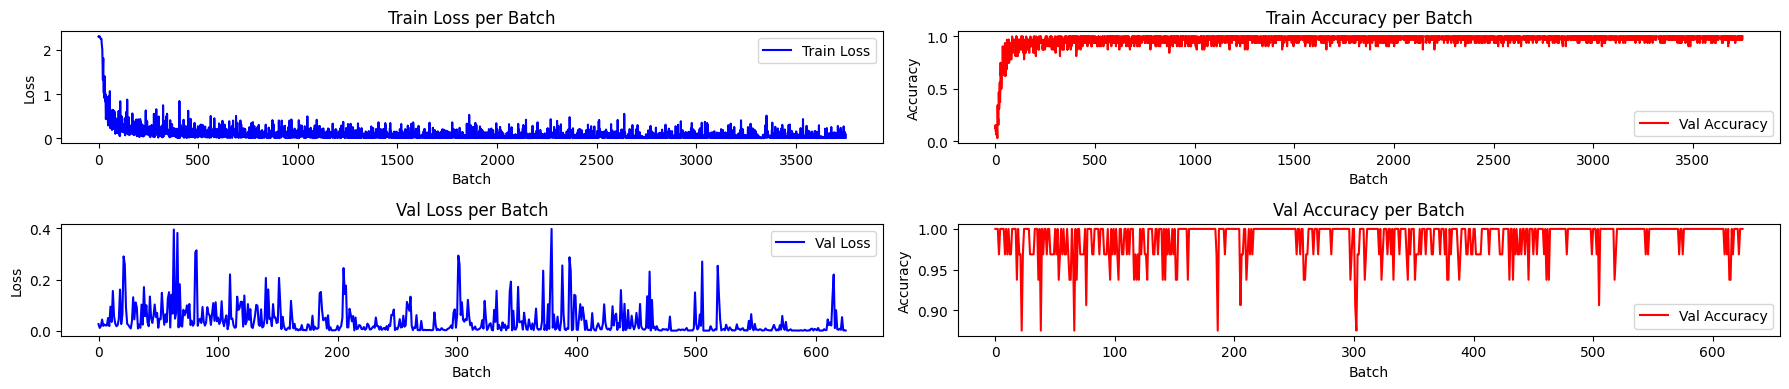

>> lr: 0.001


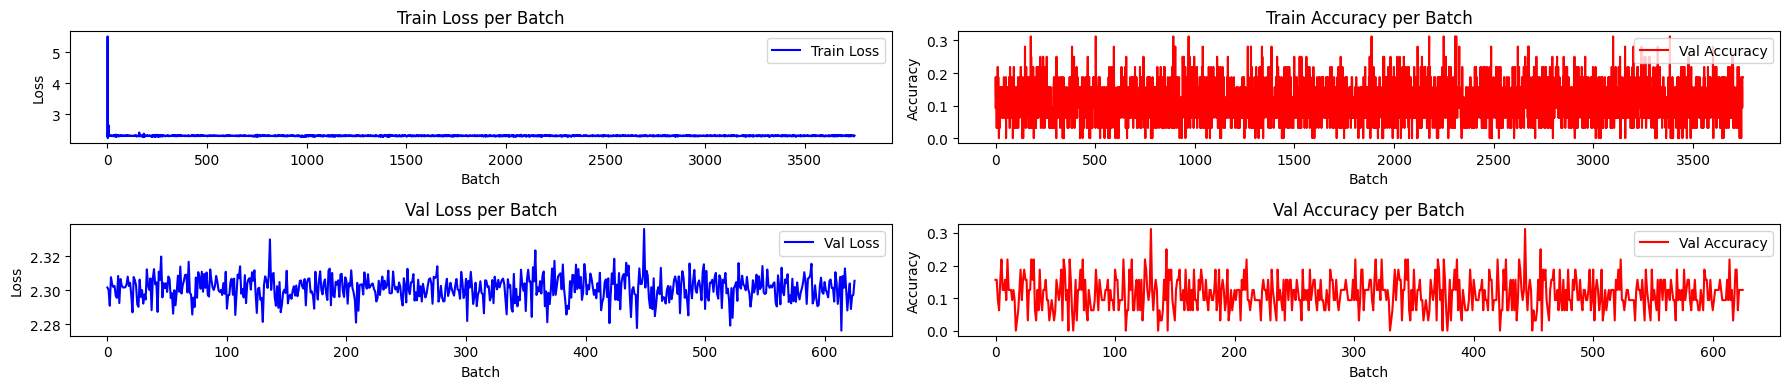

>> lr: 0.005


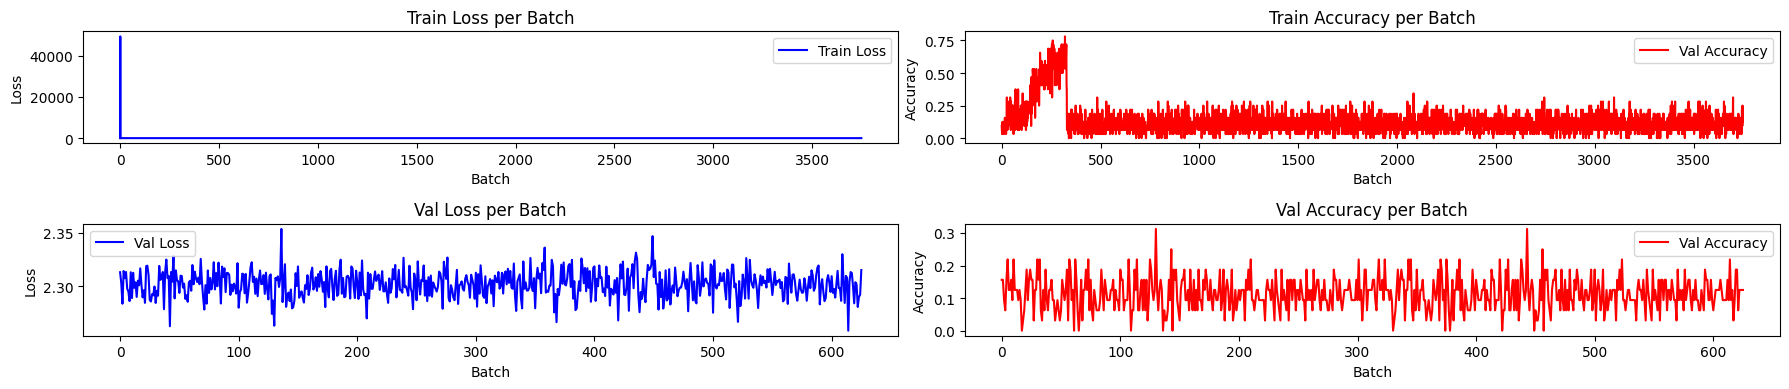

>> lr: 0.01


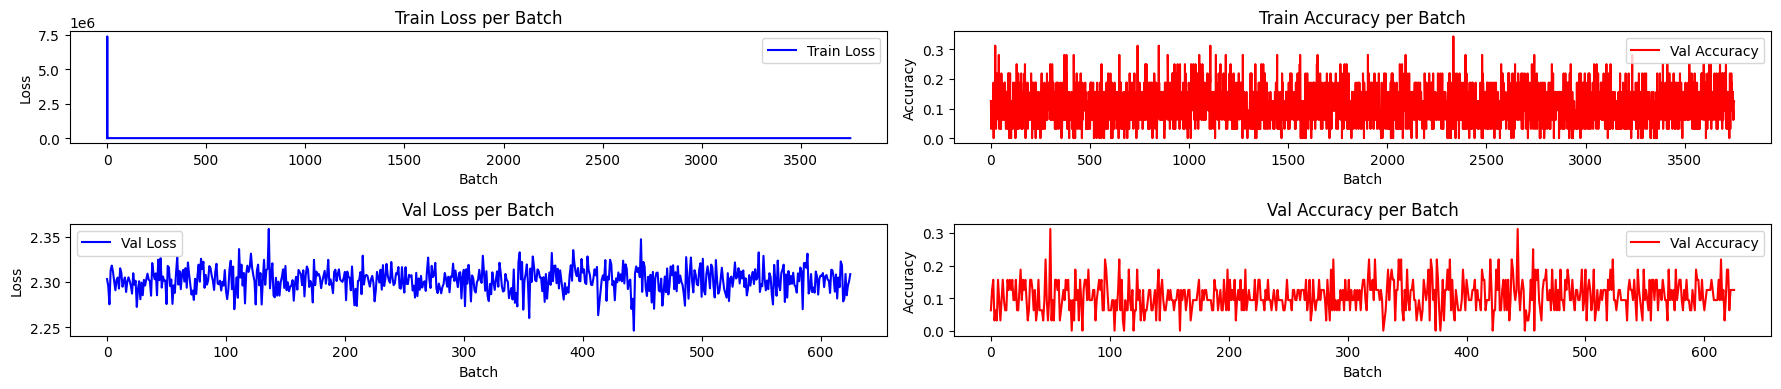

In [10]:
# 可视化训练过程中的loss和accuracy
for tls, taccs, vls, vaccs, lr in zip(TLS, TACC, VLS, VACC, LR):
    print(f'>> lr: {lr}')
    plt.figure(figsize=(18, 4))
    
    # 绘制训练Loss
    plt.subplot(2, 2, 1)  # 2行2列的第1个位置
    plt.plot(tls, label='Train Loss', color='blue')
    plt.title('Train Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练Accuracy
    plt.subplot(2, 2, 2)  # 2行2列的第2位置
    plt.plot(taccs, label='Val Accuracy', color='red')
    plt.title('Train Accuracy per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 绘制验证Loss
    plt.subplot(2, 2, 3)  # 2行2列的第3个位置
    plt.plot(vls, label='Val Loss', color='blue')
    plt.title('Val Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制验证Accuracy
    plt.subplot(2, 2, 4)  # 2行2列的第4个位置
    plt.plot(vaccs, label='Val Accuracy', color='red')
    plt.title('Val Accuracy per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # 自动调整子图参数,使之填充整个图像区域
    plt.show()

## 6. layer-1 Convs

In [14]:
for lr, model in zip(LR, MODELS):
    print(f'>> lr: {lr}')
    first_conv_layer = model.features[0]  # 直接从model.features获取第一个卷积层
    
    def visualize_conv_weights(conv_layer, layer_name):
        weights = conv_layer.weight.detach().cpu()
        grid = utils.make_grid(weights, nrow=8, normalize=True, scale_each=True)
        plt.figure(figsize=(16, 8))
        plt.imshow(utils.make_grid(grid, nrow=8).permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title(f'{layer_name} Weights')
        plt.show()
    
    visualize_conv_weights(first_conv_layer, 'First Conv Layer')

>> lr: 1e-05


AttributeError: 'MaxPool2d' object has no attribute 'weight'

## 7. Confusion Matrix

>> lr: 1e-05


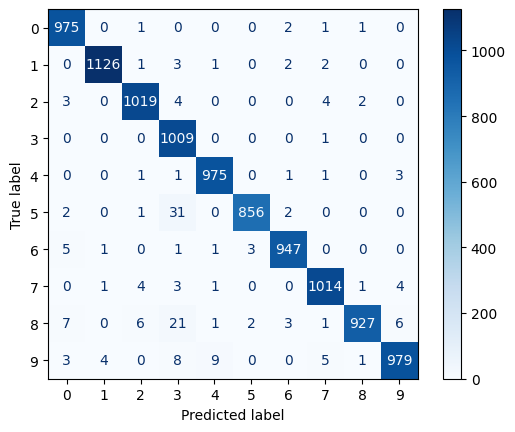

>> lr: 0.0001


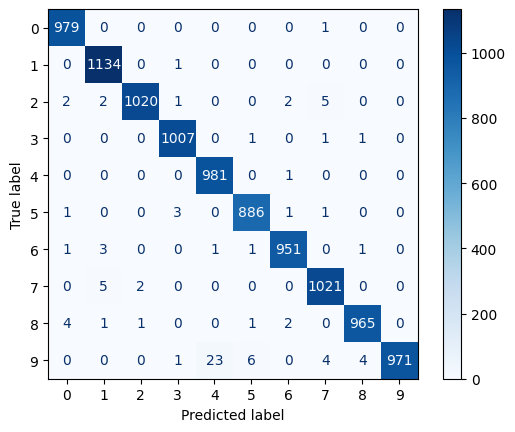

>> lr: 0.001


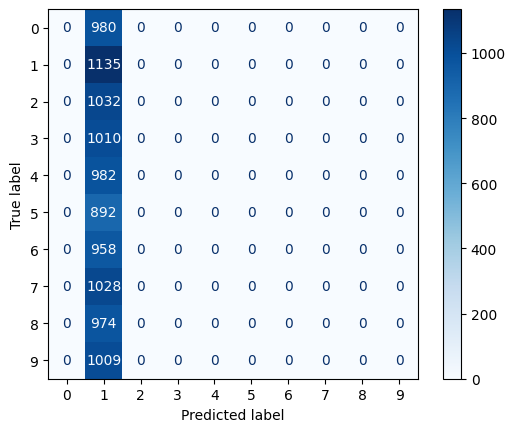

>> lr: 0.005


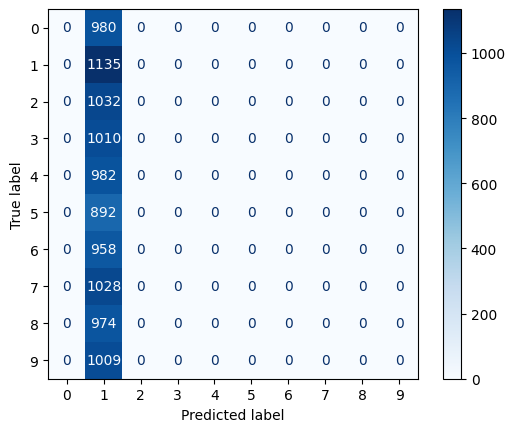

>> lr: 0.01


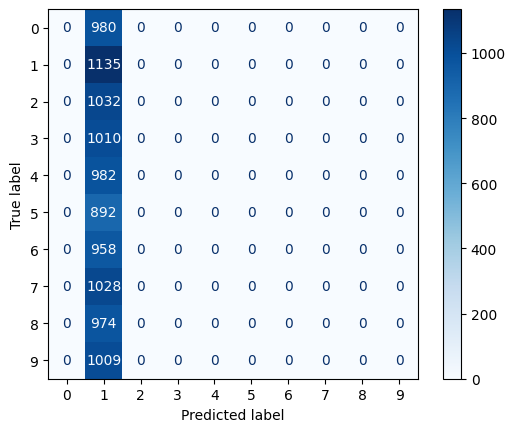

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for lr, model in zip(LR, MODELS):
    print(f'>> lr: {lr}')
    # 设置模型为评估模式
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # 禁用梯度计算，减少内存占用并加速计算
        for inputs, labels in test_loader:  # 假设test_loader返回的是(inputs, labels)对
            inputs = inputs.to(device)  # 将输入数据移到相同的设备上
            outputs = model(inputs)  # 获取模型输出
            _, preds = torch.max(outputs, 1)  # 获取预测结果
            
            all_preds.extend(preds.cpu().numpy())  # 将预测结果添加到列表
            all_labels.extend(labels.cpu().numpy())  # 将真实标签添加到列表
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))  # 假设是10类分类问题
    disp.plot(cmap=plt.cm.Blues)
    plt.show()